Created by Zain Eris Kamal (zain.eris.kamal@rutgers.edu) on 5/17/23.

Purpose:
- Representative crustal thickness in Henry crater without layering.
    - Henry crater has layering, likely aeolian deposits, which bias Wieczorek's crustal thickness data (derived from topology minus moho).  
- Calculate the range of crustal thickness value at Henry crater with different interior models.

---
---
## 0. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import zerisk.Utils as utils

In [3]:
''' Load crater data '''

import zerisk.Craters

path__datahome = utils.getPath('current','..','data','1_raw')

Craters = zerisk.Craters.Craters()
Craters.downloadData(path__datahome, overwrite=False, verbose=True)

Craters.loadData(minDiam=70, maxDiam=1000, extraInfo=True)

Data folder already exists at 
c:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\craters. 
To overwrite, add `overwrite=True` param.



In [4]:
''' Load crustal thickness data '''

import zerisk.Crust
Crust = zerisk.Crust.Crust()

path__datahome = utils.getPath('current','..','data','1_raw')
Crust.downloadData(path__datahome, overwrite=False, verbose=True)

Crust.loadData(spacing=0.1)

Data folder already exists at 
c:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\crustal_thickness. 
To overwrite, add `overwrite=True` param.



---
---
## 1. Previous Work

### 1.1. Elevation

![](https://files.catbox.moe/tr7lso.png)

---
### 1.2. Wieczorek Crustal Thickness Map

In [6]:
def plotCrater(crater_name, scaling, spacing):
    thiscrater = Craters.getByName(crater_name)
    radius_th = Craters.km2theta(thiscrater['diam']/2)

    lon_left = thiscrater['lon']-radius_th*scaling
    lon_right = thiscrater['lon']+radius_th*scaling
    lat_bottom = thiscrater['lat']-radius_th*scaling
    lat_top = thiscrater['lat']+radius_th*scaling

    dat = []

    for lat in np.arange(lat_bottom, lat_top, spacing):
        newline = []
        for lon in np.arange(lon_left, lon_right, spacing):
            x = Crust.getThickness(lon, lat)
            newline.append(x)
        dat.append(newline)

        
    # dat = np.asarray(dat)
    # dat = np.ma.masked_where((dat == GRS.getNanVal()), dat)

    fig = plt.figure(figsize=(10,7))
    ax = plt.axes()
    im = ax.imshow(dat[::-1], cmap='jet', extent=[lon_left, lon_right, lat_bottom, lat_top])

    cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
    cbar = plt.colorbar(im, cax=cax)

    ax.set_title('Crustal Thickness at Henry Crater')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    ax.xaxis.set_major_formatter('{x}$\degree$')
    ax.yaxis.set_major_formatter('{x}$\degree$')

    cbar.set_label('Crustal Thickness (km)',y=0.5)

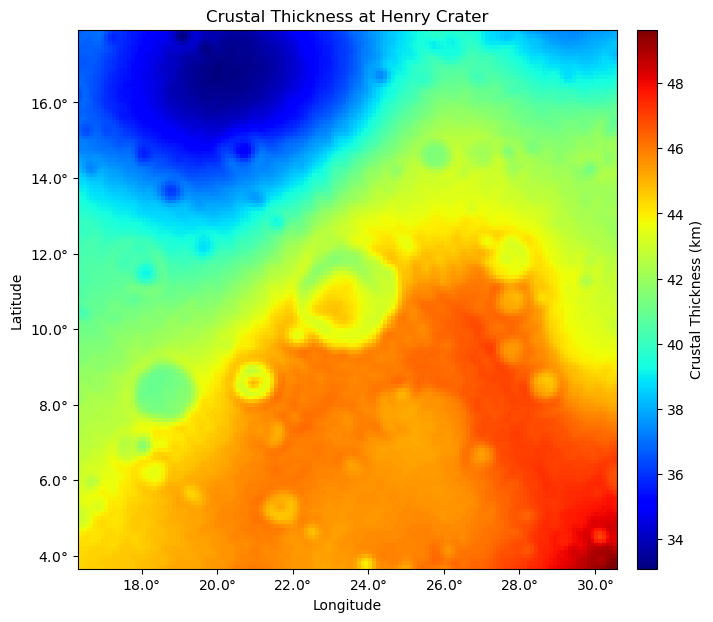

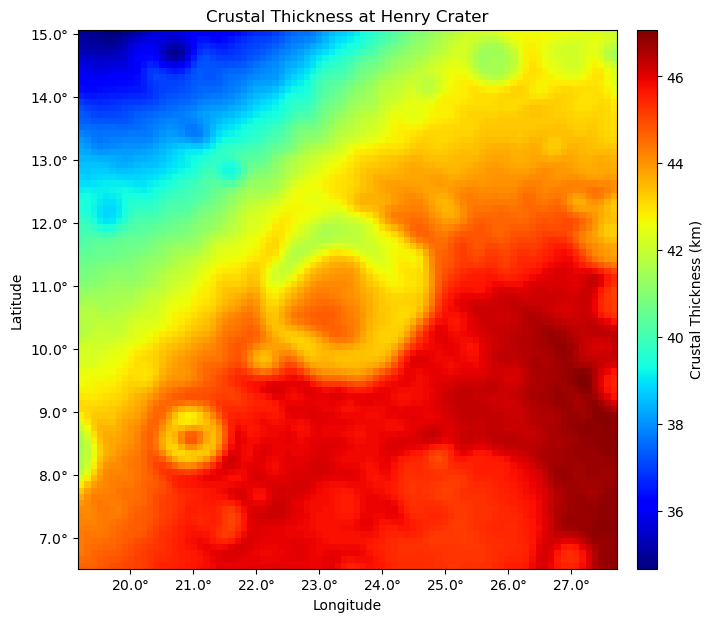

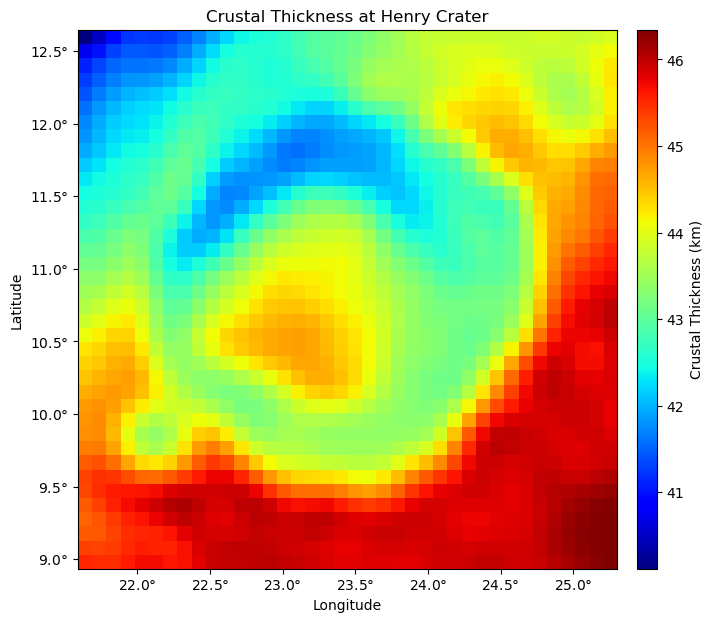

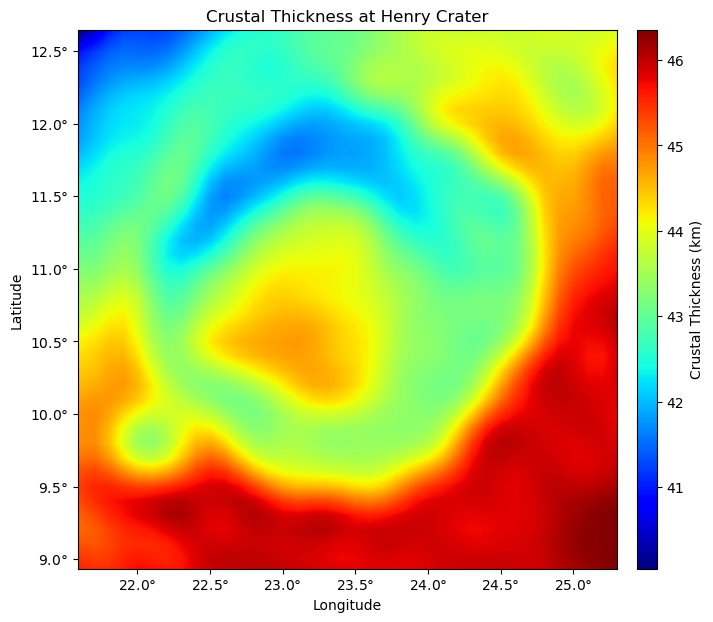

In [15]:
crater_name = 'Henry'
plotCrater(crater_name, 5, 0.1)
plotCrater(crater_name, 3, 0.1)
plotCrater(crater_name, 1.3, 0.1)
plotCrater(crater_name, 1.3, 0.01)

### 1.3. Wieczorek Crustal Thickness Cross-Section

Text(0, 0.5, 'Crustal Thickness [km]')

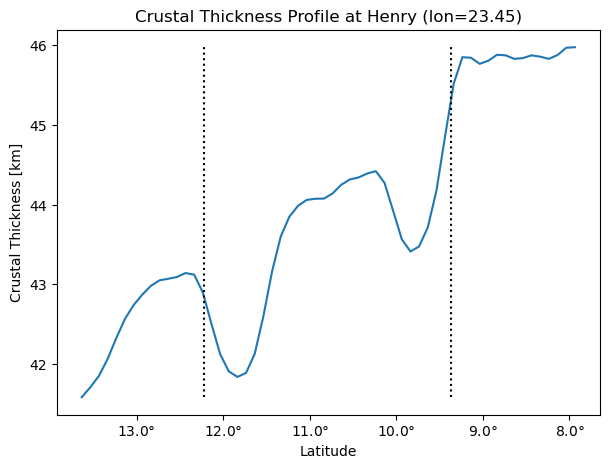

In [78]:
crater_name = 'Henry'
scaling = 2
spacing = 0.1


thiscrater = Craters.getByName(crater_name)
radius_th = Craters.km2theta(thiscrater['diam']/2)


lon = thiscrater['lon']
crater_lat_bottom = thiscrater['lat']-radius_th
crater_lat_top = thiscrater['lat']+radius_th
lat_bottom = thiscrater['lat']-radius_th*scaling
lat_top = thiscrater['lat']+radius_th*scaling


lat_range = np.arange(lat_bottom, lat_top, spacing)


dat = []

for lat in lat_range:
    dat.append(Crust.getThickness(lon, lat))




fig = plt.figure(figsize=(7,5))
ax = plt.axes()
lin = ax.plot(lat_range, dat)

ax.invert_xaxis()

ax.vlines(x=[crater_lat_bottom, crater_lat_top], ymin=np.amin(dat), ymax=np.amax(dat), colors='k', linestyles='dotted')

ax.set_title(f'Crustal Thickness Profile at {crater_name} (lon={lon:0.2f})')
ax.set_xlabel('Latitude')
ax.xaxis.set_major_formatter('{x}$\degree$')
ax.set_ylabel('Crustal Thickness [km]')